In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import shap

# import dataset

current_os = 'mac'
if current_os == 'mac':
    path = '/Users/fabienaugsburger/Documents/GitHub/master-project/'
elif current_os == 'win':
    path = 'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    print('Error: OS not recognized')

# load data

dataset = 'X_y_EU_1h'
osaa = 2

if osaa == '':
    X_train = np.load(path + f'DATASETS/{dataset}/X_train.npy')
    X_test = np.load(path + f'DATASETS/{dataset}/X_test.npy')
    y_train = np.load(path + f'DATASETS/{dataset}/y_train.npy')
    y_test = np.load(path + f'DATASETS/{dataset}/y_test.npy')
    X_validation = np.load(path + f'DATASETS/{dataset}/X_validation.npy')
    y_validation = np.load(path + f'DATASETS/{dataset}/y_validation.npy')
else:
    X_train = np.load(path + f'DATASETS/{dataset}/X_train_{osaa}.npy')
    X_test = np.load(path + f'DATASETS/{dataset}/X_test_{osaa}.npy')
    y_train = np.load(path + f'DATASETS/{dataset}/y_train_{osaa}.npy')
    y_test = np.load(path + f'DATASETS/{dataset}/y_test_{osaa}.npy')
    X_validation = np.load(path + f'DATASETS/{dataset}/X_validation_{osaa}.npy')
    y_validation = np.load(path + f'DATASETS/{dataset}/y_validation_{osaa}.npy')



names = pd.read_csv(path + f'variable_list_24_v5_wo_i.csv')

if osaa == 2:
    X_train=pd.DataFrame(X_train, columns=names['variables'])
    X_test=pd.DataFrame(X_test, columns=names['variables'])
    X_validation=pd.DataFrame(X_validation, columns=names['variables'])
    
    y_train=pd.DataFrame(y_train, columns=['instantaneous_10m_wind_gust_0'])
    y_test=pd.DataFrame(y_test, columns=['instantaneous_10m_wind_gust_0'])
    y_validation=pd.DataFrame(y_validation, columns=['instantaneous_10m_wind_gust_0'])

# List of regressors to test
regressors = {
    'RandomForest': RandomForestRegressor(),
    'LightGBM': LGBMRegressor(),
    'XGBoost': XGBRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge()
}

# Function to evaluate a regressor and plot SHAP values
def evaluate_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    #explainer = shap.Explainer(regressor, X_train)
    #shap_values = explainer(X_test)
    #shap.summary_plot(shap_values, X_test)
    
    return mse

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Evaluate all regressors
results = {}
for name, regressor in regressors.items():
    print(f"Evaluating {name}...")
    mse = evaluate_regressor(regressor, X_train, y_train, X_test, y_test)
    results[name] = mse

# Display results
results_df = pd.DataFrame(list(results.items()), columns=['Regressor', 'MSE'])
print(results_df)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Evaluating RandomForest...
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
Evaluating XGBoost...
Evaluating GradientBoosting...
Evaluating LinearRegression...
Evaluating Ridge...
          Regressor       MSE
0      RandomForest  6.065921
1          LightGBM  5.290954
2           XGBoost  5.149497
3  GradientBoosting  4.992253
4  LinearRegression  5.082993
5             Ridge  4.751354


In [2]:
import optuna
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from optuna.samplers import TPESampler

# Define objective functions for each regressor

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_lgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    
    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_lr(trial):
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_ridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)
    
    model = Ridge(alpha=alpha, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Dictionary to hold the studies for each model
studies = {
    'RandomForest': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'LightGBM': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'XGBoost': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'GradientBoosting': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'LinearRegression': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'Ridge': optuna.create_study(direction='minimize', sampler=TPESampler())
}

# Dictionary to map models to their objective functions
objectives = {
    'RandomForest': objective_rf,
    'LightGBM': objective_lgbm,
    'XGBoost': objective_xgb,
    'GradientBoosting': objective_gb,
    'LinearRegression': objective_lr,
    'Ridge': objective_ridge
}

# Run the optimization for each regressor
for name, study in studies.items():
    print(f"Optimizing {name}...")
    study.optimize(objectives[name], n_trials=100)
    print(f"Best hyperparameters for {name}: {study.best_params}")
    print(f"Best MSE for {name}: {study.best_value}")

# Print all the best hyperparameters and their MSEs
for name, study in studies.items():
    print(f"\n{name} best hyperparameters: {study.best_params}")
    print(f"{name} best MSE: {study.best_value}")

[I 2024-06-28 18:41:00,792] A new study created in memory with name: no-name-88eb789d-6016-4b33-ad37-98ef81e9b36f
[I 2024-06-28 18:41:00,793] A new study created in memory with name: no-name-01c2f7e8-66da-484e-8209-f5f30f69aee6
[I 2024-06-28 18:41:00,795] A new study created in memory with name: no-name-0aaf92fe-2a2a-4bd3-a51a-b945959ecda1
[I 2024-06-28 18:41:00,796] A new study created in memory with name: no-name-463abbc5-a595-415b-9cb3-a10fcc5ad96c
[I 2024-06-28 18:41:00,797] A new study created in memory with name: no-name-a73af20a-e0e4-4d2a-9743-e891c296e7ca
[I 2024-06-28 18:41:00,797] A new study created in memory with name: no-name-0b4428b0-036f-4a40-bdce-51cac162aacd


Optimizing RandomForest...


[I 2024-06-28 18:41:13,401] Trial 0 finished with value: 6.2548955261313095 and parameters: {'n_estimators': 120, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 6.2548955261313095.
[I 2024-06-28 18:41:16,558] Trial 1 finished with value: 6.4061369799588395 and parameters: {'n_estimators': 30, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 6.2548955261313095.
[I 2024-06-28 18:41:27,279] Trial 2 finished with value: 6.0561835695708215 and parameters: {'n_estimators': 75, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: 6.0561835695708215.
[I 2024-06-28 18:41:36,864] Trial 3 finished with value: 6.173629138560914 and parameters: {'n_estimators': 75, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 2 with value: 6.0561835695708215.
[I 2024-06-28 18:41:55,459] Trial 4 finished with value: 6.04998241992122 and parameters: {'n_est

Best hyperparameters for RandomForest: {'n_estimators': 133, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1}
Best MSE for RandomForest: 5.9055858922141065
Optimizing LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875


[I 2024-06-28 19:10:14,335] Trial 0 finished with value: 5.716626871016804 and parameters: {'num_leaves': 55, 'max_depth': 20, 'learning_rate': 0.03430124298887477, 'n_estimators': 101}. Best is trial 0 with value: 5.716626871016804.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:15,219] Trial 1 finished with value: 5.852360523062355 and parameters: {'num_leaves': 83, 'max_depth': 10, 'learning_rate': 0.18676762761825844, 'n_estimators': 155}. Best is trial 0 with value: 5.716626871016804.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:15,643] Trial 2 finished with value: 5.405438910237432 and parameters: {'num_leaves': 55, 'max_depth': 7, 'learning_rate': 0.07569501237905403, 'n_estimators': 95}. Best is trial 2 with value: 5.405438910237432.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:16,192] Trial 3 finished with value: 5.694339267423635 and parameters: {'num_leaves': 127, 'max_depth': 6, 'learning_rate': 0.1793035025133476, 'n_estimators': 194}. Best is trial 2 with value: 5.405438910237432.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:16,578] Trial 4 finished with value: 9.51309186063347 and parameters: {'num_leaves': 148, 'max_depth': 12, 'learning_rate': 0.038098457931575555, 'n_estimators': 29}. Best is trial 2 with value: 5.405438910237432.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:17,202] Trial 5 finished with value: 6.167533208293181 and parameters: {'num_leaves': 179, 'max_depth': 8, 'learning_rate': 0.28565180335219925, 'n_estimators': 158}. Best is trial 2 with value: 5.405438910237432.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:17,239] Trial 6 finished with value: 15.543608718928407 and parameters: {'num_leaves': 193, 'max_depth': 2, 'learning_rate': 0.017439311814461785, 'n_estimators': 42}. Best is trial 2 with value: 5.405438910237432.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875


[I 2024-06-28 19:10:17,930] Trial 7 finished with value: 5.693840292821194 and parameters: {'num_leaves': 69, 'max_depth': 10, 'learning_rate': 0.04127740098291611, 'n_estimators': 88}. Best is trial 2 with value: 5.405438910237432.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:17,968] Trial 8 finished with value: 14.548417502592088 and parameters: {'num_leaves': 125, 'max_depth': 1, 'learning_rate': 0.014923685509227728, 'n_estimators': 83}. Best is trial 2 with value: 5.405438910237432.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-06-28 19:10:19,574] Trial 9 finished with value: 5.722800241269592 and parameters: {'num_leaves': 127, 'max_depth': 16, 'learning_rate': 0.19609021662051393, 'n_estimators': 175}. Best is trial 2 with value: 5.405438910237432.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:19,804] Trial 10 finished with value: 4.832638781712565 and parameters: {'num_leaves': 14, 'max_depth': 5, 'learning_rate': 0.06733947826321313, 'n_estimators': 130}. Best is trial 10 with value: 4.832638781712565.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:19,990] Trial 11 finished with value: 4.770429220287061 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.0830201671392375, 'n_estimators': 131}. Best is trial 11 with value: 4.770429220287061.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:20,174] Trial 12 finished with value: 4.772322515674944 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.08582191124590237, 'n_estimators': 135}. Best is trial 11 with value: 4.770429220287061.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:20,340] Trial 13 finished with value: 4.6926937111290545 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09507852127012839, 'n_estimators': 131}. Best is trial 13 with value: 4.6926937111290545.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:20,878] Trial 14 finished with value: 4.851822474198603 and parameters: {'num_leaves': 31, 'max_depth': 4, 'learning_rate': 0.11568738559173793, 'n_estimators': 125}. Best is trial 13 with value: 4.6926937111290545.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875


[I 2024-06-28 19:10:21,223] Trial 15 finished with value: 5.389581294382481 and parameters: {'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.10925179633033409, 'n_estimators': 68}. Best is trial 13 with value: 4.6926937111290545.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:21,307] Trial 16 finished with value: 6.81672978074118 and parameters: {'num_leaves': 38, 'max_depth': 2, 'learning_rate': 0.02595472272690274, 'n_estimators': 118}. Best is trial 13 with value: 4.6926937111290545.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-06-28 19:10:24,219] Trial 17 finished with value: 5.475762926075432 and parameters: {'num_leaves': 92, 'max_depth': 8, 'learning_rate': 0.05782011002927959, 'n_estimators': 149}. Best is trial 13 with value: 4.6926937111290545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:24,288] Trial 18 finished with value: 4.661234361150494 and parameters: {'num_leaves': 11, 'max_depth': 3, 'learning_rate': 0.11533830179899843, 'n_estimators': 60}. Best is trial 18 with value: 4.661234361150494.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:24,725] Trial 19 finished with value: 5.384561450322187 and parameters: {'num_leaves': 58, 'max_depth': 16, 'learning_rate': 0.1257917025443459, 'n_estimators': 63}. Best is trial 18 with value: 4.661234361150494.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:24,755] Trial 20 finished with value: 6.684400685296427 and parameters: {'num_leaves': 30, 'max_depth': 1, 'learning_rate': 0.2847221861845713, 'n_estimators': 21}. Best is trial 18 with value: 4.661234361150494.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:24,861] Trial 21 finished with value: 4.545524100593885 and parameters: {'num_leaves': 17, 'max_depth': 3, 'learning_rate': 0.0888621

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-06-28 19:10:25,331] Trial 23 finished with value: 5.475940794673128 and parameters: {'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.0505319144036906, 'n_estimators': 107}. Best is trial 21 with value: 4.545524100593885.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:25,481] Trial 24 finished with value: 4.821693659003263 and parameters: {'num_leaves': 73, 'max_depth': 3, 'learning_rate': 0.09059137614255898, 'n_estimators': 111}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:25,634] Trial 25 finished with value: 17.63349647472041 and parameters: {'num_leaves': 21, 'max_depth': 8, 'learning_rate': 0.010069587990326078, 'n_estimators': 47}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:25,861] Trial 26 finished with value: 5.19902952330267 and parameters: {'num_leaves': 103, 'max_depth': 6, 'learning_rate': 0.16121073409357478, 'n_estimators': 70}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:25,954] Trial 27 finished with value: 4.980982443686048 and parameters: {'num_leaves': 46, 'max_depth': 2, 'learning_rate': 0.05812831632721002, 'n_estimators': 143}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875


[I 2024-06-28 19:10:26,210] Trial 28 finished with value: 4.77236318390553 and parameters: {'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.10722869307868205, 'n_estimators': 166}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:26,305] Trial 29 finished with value: 6.420507496529858 and parameters: {'num_leaves': 65, 'max_depth': 19, 'learning_rate': 0.2336180885281686, 'n_estimators': 10}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:26,353] Trial 30 finished with value: 8.799636428371546 and parameters: {'num_leaves': 42, 'max_depth': 1, 'learning_rate': 0.029861

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:26,421] Trial 31 finished with value: 4.981413886012987 and parameters: {'num_leaves': 28, 'max_depth': 3, 'learning_rate': 0.14229881015053122, 'n_estimators': 55}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:26,512] Trial 32 finished with value: 4.580998887245395 and parameters: {'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.13826178409712786, 'n_estimators': 89}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:26,691] Trial 33 finished with value: 5.058767261979853 and parameters: {'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.09477324378324326, 'n_estimators': 81}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:27,146] Trial 34 finished with value: 5.4537350185885884 and parameters: {'num_leaves': 50, 'max_depth': 7, 'learning_rate': 0.14814997179842704, 'n_estimators': 104}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:27,268] Trial 35 finished with value: 4.773556361163163 and parameters: {'num_leaves': 80, 'max_depth': 3, 'learning_rate': 0.06702820250203798, 'n_estimators': 116}. Best is trial 21 with value: 4.545524100593885.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-06-28 19:10:27,780] Trial 36 finished with value: 5.763256172492021 and parameters: {'num_leaves': 56, 'max_depth': 10, 'learning_rate': 0.21188711930846493, 'n_estimators': 91}. Best is trial 21 with value: 4.545524100593885.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:27,974] Trial 37 finished with value: 5.091271869117519 and parameters: {'num_leaves': 18, 'max_depth': 7, 'learning_rate': 0.07240159455382074, 'n_estimators': 80}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:28,018] Trial 38 finished with value: 5.268161233467785 and parameters: {'num_leaves': 35, 'max_depth': 2, 'learning_rate': 0.17502348181428573, 'n_estimators': 35}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-06-28 19:10:29,440] Trial 39 finished with value: 5.57971076742718 and parameters: {'num_leaves': 168, 'max_depth': 9, 'learning_rate': 0.04871796826434951, 'n_estimators': 180}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875


[I 2024-06-28 19:10:29,850] Trial 40 finished with value: 5.4679958295477675 and parameters: {'num_leaves': 23, 'max_depth': 12, 'learning_rate': 0.24388073131054194, 'n_estimators': 141}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:29,918] Trial 41 finished with value: 4.767469191189708 and parameters: {'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.127076187002616, 'n_estimators': 58}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:30,031] Trial 42 finished with value: 5.021717852607398 and parameters: {'num_leaves': 21, 'max_depth': 4, 'learning_rate': 0.10214

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:30,200] Trial 43 finished with value: 5.421451548427651 and parameters: {'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.1378683007692268, 'n_estimators': 49}. Best is trial 21 with value: 4.545524100593885.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:30,250] Trial 44 finished with value: 6.0837723833824775 and parameters: {'num_leaves': 11, 'max_depth': 1, 'learning_rate': 0.07782692772654846, 'n_estimators': 93}. Best is trial 21 with value: 4.545524100593885.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:30,537] Trial 45 finished with value: 5.0577280262864015 and parameters: {'num_leaves': 50, 'max_depth': 5, 'learning_rate': 0.1202461854854014, 'n_estimators': 122}. Best is trial 21 with value: 4.545524100593885.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:30,611] Trial 46 finished with value: 4.492261976963209 and parameters: {'num_leaves': 138, 'max_depth': 2, 'learning_rate': 0.16954923983097353, 'n_estimators': 103}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:30,682] Trial 47 finished with value: 4.688706884211875 and parameters: {'num_leaves': 138, 'max_depth': 2, 'learning_rate': 0.16933701591703143, 'n_estimators': 104}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used featur

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:30,800] Trial 49 finished with value: 5.48469288703199 and parameters: {'num_leaves': 153, 'max_depth': 1, 'learning_rate': 0.19313418065047952, 'n_estimators': 101}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:30,875] Trial 50 finished with value: 4.766936772197103 and parameters: {'num_leaves': 118, 'max_depth': 2, 'learning_rate': 0.2253567751723085, 'n_estimators': 110}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-06-28 19:10:31,086] Trial 51 finished with value: 4.759693157222019 and parameters: {'num_leaves': 152, 'max_depth': 4, 'learning_rate': 0.1717623734844728, 'n_estimators': 126}. Best is trial 46 with value: 4.492261976963209.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:31,271] Trial 52 finished with value: 5.098754057950095 and parameters: {'num_leaves': 165, 'max_depth': 4, 'learning_rate': 0.0960784293977771, 'n_estimators': 136}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:31,380] Trial 53 finished with value: 4.551070828196332 and parameters: {'num_leaves': 115, 'max_depth': 3, 'learning_rate': 0.11458296700682273, 'n_estimators': 116}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:31,457] Trial 54 finished with value: 4.70524874091113 and parameters: {'num_leaves': 137, 'max_depth': 2, 'learning_rate': 0.26176278432031885, 'n_estimators': 115}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:31,717] Trial 55 finished with value: 4.863434340991392 and parameters: {'num_leaves': 123, 'max_depth': 5, 'learning_rate': 0.19493655437184634, 'n_estimators': 103}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:31,807] Trial 56 finished with value: 4.667389504669151 and parameters: {'num_leaves': 113, 'max_depth': 3, 'learning_rate': 0.1117572602471173, 'n_estimators': 88}. Best is trial 46 with value: 4.492261976963209.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:31,885] Trial 57 finished with value: 4.932943903836576 and parameters: {'num_leaves': 113, 'max_depth': 3, 'learning_rate': 0.1098004906172396, 'n_estimators': 73}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:32,728] Trial 58 finished with value: 5.617413534873057 and parameters: {'num_leaves': 97, 'max_depth': 14, 'learning_rate': 0.08499027293324937, 'n_estimators': 94}. Best is trial 46 with value: 4.492261976963209.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:32,819] Trial 59 finished with value: 5.610441574510156 and parameters: {'num_leaves': 108, 'max_depth': 1, 'learning_rate': 0.14969127824013137, 'n_estimators': 86}. Best is trial 46 with value: 4.492261976963209.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM]

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:33,278] Trial 60 finished with value: 5.525232496890614 and parameters: {'num_leaves': 90, 'max_depth': 7, 'learning_rate': 0.06701195525749036, 'n_estimators': 76}. Best is trial 46 with value: 4.492261976963209.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:33,385] Trial 61 finished with value: 4.399637480471605 and parameters: {'num_leaves': 128, 'max_depth': 3, 'learning_rate': 0.1260345509603565, 'n_estimators': 110}. Best is trial 61 with value: 4.399637480471605.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:33,548] Trial 62 finished with value: 4.54425233394257 and parameters: {'num_leaves': 130, 'max_depth': 3, 'learning_rate': 0.1203886867177207, 'n_estimators': 120}. Best is trial 61 with value: 4.399637480471605.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:33,716] Trial 63 finished with value: 5.075800918481318 and parameters: {'num_leaves': 129, 'max_depth': 4, 'learning_rate': 0.12382933122268862, 'n_estimators': 123}. Best is trial 61 with value: 4.399637480471605.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train 

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:34,090] Trial 64 finished with value: 5.17570582810268 and parameters: {'num_leaves': 145, 'max_depth': 6, 'learning_rate': 0.14548056723298758, 'n_estimators': 113}. Best is trial 61 with value: 4.399637480471605.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:34,261] Trial 65 finished with value: 5.327380648401637 and parameters: {'num_leaves': 132, 'max_depth': 4, 'learning_rate': 0.12948158153569186, 'n_estimators': 118}. Best is trial 61 with value: 4.399637480471605.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:34,386] Trial 66 finished with value: 4.546388529560817 and parameters: {'num_leaves': 195, 'max_depth': 3, 'learning_rate': 0.10001751599813818, 'n_estimators': 130}. Best is trial 61 with value: 4.399637480471605.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:34,721] Trial 67 finished with value: 5.278742323626536 and parameters: {'num_leaves': 200, 'max_depth': 5, 'learning_rate': 0.10236556108234021, 'n_estimators': 151}. Best is trial 61 with value: 4.399637480471605.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:34,787] Trial 68 finished with value: 5.507792267654308 and parameters: {'num_leaves': 123, 'max_depth': 1, 'learning_rate': 0.07907878232813727, 'n_estimators': 136}. Best is trial 61 with value: 4.399637480471605.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:36,361] Trial 69 finished with value: 5.927920367803595 and parameters: {'num_leaves': 183, 'max_depth': 20, 'learning_rate': 0.08789055901513405, 'n_estimators': 129}. Best is trial 61 with value: 4.399637480471605.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:36,458] Trial 70 finished with value: 4.686573137657133 and parameters: {'num_leaves': 160, 'max_depth': 2, 'learning_rate': 0.09829251836771238, 'n_estimators': 162}. Best is trial 61 with value: 4.399637480471605.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:36,563] Trial 71 finished with value: 4.501384042448216 and parameters: {'num_leaves': 174, 'max_depth': 3, 'learning_rate': 0.11576037182895269, 'n_estimators': 108}. Best is trial 61 with value: 4.399637480471605.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:36,661] Trial 72 finished with value: 4.429828952589898 and parameters: {'num_leaves': 186, 'max_depth': 3, 'learning_rate': 0.15797064252535564, 'n_estimators': 98}. Best is trial 61 with value: 4.399637480471605.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:36,807] Trial 73 finished with value: 4.3060556224421385 and parameters: {'num_leaves': 185, 'max_depth': 3, 'learning_rate': 0.15342868710171523, 'n_estimators': 108}. Best is trial 73 with value: 4.3060556224421385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:36,953] Trial 74 finished with value: 5.121580911451203 and parameters: {'num_leaves': 182, 'max_depth': 4, 'learning_rate': 0.15345390079585955, 'n_estimators': 98}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:37,028] Trial 75 finished with value: 4.56516818148168 and parameters: {'num_leaves': 191, 'max_depth': 2, 'learning_rate': 0.20529033228223958, 'n_estimators': 109}. Best is trial 73 with value: 4.3060556224421385.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:37,181] Trial 76 finished with value: 5.1777333785312045 and parameters: {'num_leaves': 175, 'max_depth': 4, 'learning_rate': 0.1761603559973475, 'n_estimators': 109}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-06-28 19:10:37,428] Trial 77 finished with value: 5.024631834211139 and parameters: {'num_leaves': 190, 'max_depth': 5, 'learning_rate': 0.12940378638606584, 'n_estimators': 121}. Best is trial 73 with value: 4.3060556224421385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:37,534] Trial 78 finished with value: 5.356458347793881 and parameters: {'num_leaves': 200, 'max_depth': 1, 'learning_rate': 0.15570636592754594, 'n_estimators': 141}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:37,642] Trial 79 finished with value: 6.892739662284639 and parameters: {'num_leaves': 173, 'max_depth': 3, 'learning_rate': 0.02131921694346307, 'n_estimators': 99}. Best is trial 73 with value: 4.3060556224421385.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start t

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:38,544] Trial 80 finished with value: 6.108964095649129 and parameters: {'num_leaves': 186, 'max_depth': 11, 'learning_rate': 0.21546256680124834, 'n_estimators': 129}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:38,700] Trial 81 finished with value: 4.476907518907808 and parameters: {'num_leaves': 193, 'max_depth': 3, 'learning_rate': 0.11575112050407352, 'n_estimators': 117}. Best is trial 73 with value: 4.3060556224421385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:38,771] Trial 82 finished with value: 4.726149891387428 and parameters: {'num_leaves': 196, 'max_depth': 2, 'learning_rate': 0.12015384399431012, 'n_estimators': 96}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:38,875] Trial 83 finished with value: 4.4905459551695435 and parameters: {'num_leaves': 177, 'max_depth': 3, 'learning_rate': 0.1372708122361886, 'n_estimators': 105}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-06-28 19:10:38,974] Trial 84 finished with value: 4.496034334499409 and parameters: {'num_leaves': 172, 'max_depth': 3, 'learning_rate': 0.13772079979674537, 'n_estimators': 104}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:39,122] Trial 85 finished with value: 4.965596927981765 and parameters: {'num_leaves': 173, 'max_depth': 4, 'learning_rate': 0.18059216173409115, 'n_estimators': 105}. Best is trial 73 with value: 4.3060556224421385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:39,235] Trial 86 finished with value: 4.641726591126236 and parameters: {'num_leaves': 179, 'max_depth': 2, 'learning_rate': 0.13958841368730532, 'n_estimators': 120}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Wa

[I 2024-06-28 19:10:39,551] Trial 87 finished with value: 5.585324660832302 and parameters: {'num_leaves': 160, 'max_depth': 6, 'learning_rate': 0.16378807695969552, 'n_estimators': 106}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:39,609] Trial 88 finished with value: 7.441577093275514 and parameters: {'num_leaves': 187, 'max_depth': 1, 'learning_rate': 0.0397480396037098, 'n_estimators': 113}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:39,700] Trial 89 finished with value: 4.451148729800652 and parameters: {'num_leaves': 166, 'max_depth': 3, 'learning_rate': 0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-06-28 19:10:39,891] Trial 90 finished with value: 5.469781155692698 and parameters: {'num_leaves': 167, 'max_depth': 5, 'learning_rate': 0.29574489047125735, 'n_estimators': 93}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:39,974] Trial 91 finished with value: 4.450000678397036 and parameters: {'num_leaves': 162, 'max_depth': 3, 'learning_rate': 0.19467397298824538, 'n_estimators': 82}. Best is trial 73 with value: 4.3060556224421385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:40,040] Trial 92 finished with value: 4.797477803289825 and parameters: {'num_leaves': 159, 'max_depth': 2, 'learning_rate': 0.19254990218247917, 'n_estimators': 85}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:40,172] Trial 93 finished with value: 4.454769757306418 and parameters: {'num_leaves': 179, 'max_depth': 3, 'learning_rate': 0.2445990992998614, 'n_estimators': 80}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:40,350] Trial 94 finished with value: 4.997228296965541 and parameters: {'num_leaves': 179, 'max_depth': 4, 'learning_rate': 0.252010900879128, 'n_estimators': 82}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-28 19:10:40,623] Trial 95 finished with value: 4.736121089884145 and parameters: {'num_leaves': 166, 'max_depth': 4, 'learning_rate': 0.2625792157373816, 'n_estimators': 68}. Best is trial 73 with value: 4.3060556224421385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:40,741] Trial 96 finished with value: 4.428284625707014 and parameters: {'num_leaves': 147, 'max_depth': 2, 'learning_rate': 0.22164544184923654, 'n_estimators': 101}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:40,801] Trial 97 finished with value: 4.94690816923918 and parameters: {'num_leaves': 144, 'max_depth': 2, 'learning_rate': 0.22635821729469954, 'n_estimators': 79}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM]

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:10:40,924] Trial 99 finished with value: 5.263641071755189 and parameters: {'num_leaves': 150, 'max_depth': 1, 'learning_rate': 0.23763080828280883, 'n_estimators': 100}. Best is trial 73 with value: 4.3060556224421385.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19204
[LightGBM] [Info] Number of data points in the train set: 4959, number of used features: 79
[LightGBM] [Info] Start training from score 13.872875
Best hyperparameters for LightGBM: {'num_leaves': 185, 'max_depth': 3, 'learning_rate': 0.15342868710171523, 'n_estimators': 108}
Best MSE for LightGBM: 4.3060556224421385
Optimizing XGBoost...


[I 2024-06-28 19:10:42,590] Trial 0 finished with value: 10.337277253610146 and parameters: {'n_estimators': 70, 'max_depth': 20, 'learning_rate': 0.015271518058498497, 'subsample': 0.7164565321953946}. Best is trial 0 with value: 10.337277253610146.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-06-28 19:10:43,343] Trial 1 finished with value: 5.233697878411171 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.055923411238870076, 'subsample': 0.7967998183212601}. Best is trial 1 with value: 5.233697878411171.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

Best hyperparameters for XGBoost: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.260313175808292, 'subsample': 0.9153768954074978}
Best MSE for XGBoost: 3.9972058216538637
Optimizing GradientBoosting...


[I 2024-06-28 19:11:46,604] Trial 0 finished with value: 6.606499752471648 and parameters: {'n_estimators': 106, 'max_depth': 2, 'learning_rate': 0.030995348287811843, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 6.606499752471648.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:12:07,335] Trial 1 finished with value: 7.469637943165777 and parameters: {'n_estimators': 71, 'max_depth': 12, 'learning_rate': 0.2695998553734393, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 6.606499752471648.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 19:12:44,927] Trial 2 finished with value: 5.6781029148456446 and parameters: {'n_

Best hyperparameters for GradientBoosting: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.21523198305089347, 'min_samples_split': 6, 'min_samples_leaf': 9}
Best MSE for GradientBoosting: 4.38673924519012
Optimizing LinearRegression...


[I 2024-06-28 20:18:50,818] Trial 5 finished with value: 5.082993278915512 and parameters: {}. Best is trial 0 with value: 5.082993278915512.
[I 2024-06-28 20:18:50,890] Trial 6 finished with value: 5.082993278915512 and parameters: {}. Best is trial 0 with value: 5.082993278915512.
[I 2024-06-28 20:18:50,929] Trial 7 finished with value: 5.082993278915512 and parameters: {}. Best is trial 0 with value: 5.082993278915512.
[I 2024-06-28 20:18:50,950] Trial 8 finished with value: 5.082993278915512 and parameters: {}. Best is trial 0 with value: 5.082993278915512.
[I 2024-06-28 20:18:50,983] Trial 9 finished with value: 5.082993278915512 and parameters: {}. Best is trial 0 with value: 5.082993278915512.
[I 2024-06-28 20:18:51,004] Trial 10 finished with value: 5.082993278915512 and parameters: {}. Best is trial 0 with value: 5.082993278915512.
[I 2024-06-28 20:18:51,038] Trial 11 finished with value: 5.082993278915512 and parameters: {}. Best is trial 0 with value: 5.082993278915512.
[I 2

Best hyperparameters for LinearRegression: {}
Best MSE for LinearRegression: 5.082993278915512
Optimizing Ridge...


[I 2024-06-28 20:18:53,762] Trial 15 finished with value: 4.740889306616132 and parameters: {'alpha': 2.4422347223038456}. Best is trial 15 with value: 4.740889306616132.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 20:18:53,802] Trial 16 finished with value: 4.819335574723333 and parameters: {'alpha': 0.1777852866430268}. Best is trial 15 with value: 4.740889306616132.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-06-28 20:18:53,818] Trial 17 finished with value: 4.740772893098545 and parameters: {'alpha': 2.7145237632630477}. Best is trial 17 with value: 4.740772893098545.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu

Best hyperparameters for Ridge: {'alpha': 2.7145237632630477}
Best MSE for Ridge: 4.740772893098545

RandomForest best hyperparameters: {'n_estimators': 133, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1}
RandomForest best MSE: 5.9055858922141065

LightGBM best hyperparameters: {'num_leaves': 185, 'max_depth': 3, 'learning_rate': 0.15342868710171523, 'n_estimators': 108}
LightGBM best MSE: 4.3060556224421385

XGBoost best hyperparameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.260313175808292, 'subsample': 0.9153768954074978}
XGBoost best MSE: 3.9972058216538637

GradientBoosting best hyperparameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.21523198305089347, 'min_samples_split': 6, 'min_samples_leaf': 9}
GradientBoosting best MSE: 4.38673924519012

LinearRegression best hyperparameters: {}
LinearRegression best MSE: 5.082993278915512

Ridge best hyperparameters: {'alpha': 2.7145237632630477}
Ridge best MSE: 4.740772893098545


RandomForest  6.065921

LightGBM  5.290954

XGBoost  5.149497

GradientBoosting  4.992253

LinearRegression  5.082993

Ridge  4.751354

With tuning:

Best hyperparameters for Ridge: {'alpha': 2.7145237632630477}
Best MSE for Ridge: 4.740772893098545

RandomForest best hyperparameters: {'n_estimators': 133, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1}
RandomForest best MSE: 5.9055858922141065

LightGBM best hyperparameters: {'num_leaves': 185, 'max_depth': 3, 'learning_rate': 0.15342868710171523, 'n_estimators': 108}
LightGBM best MSE: 4.3060556224421385

XGBoost best hyperparameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.260313175808292, 'subsample': 0.9153768954074978}
XGBoost best MSE: 3.9972058216538637

GradientBoosting best hyperparameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.21523198305089347, 'min_samples_split': 6, 'min_samples_leaf': 9}
GradientBoosting best MSE: 4.38673924519012

LinearRegression best hyperparameters: {}
LinearRegression best MSE: 5.082993278915512

Ridge best hyperparameters: {'alpha': 2.7145237632630477}
Ridge best MSE: 4.740772893098545

 99%|===================| 1318/1335 [01:08<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


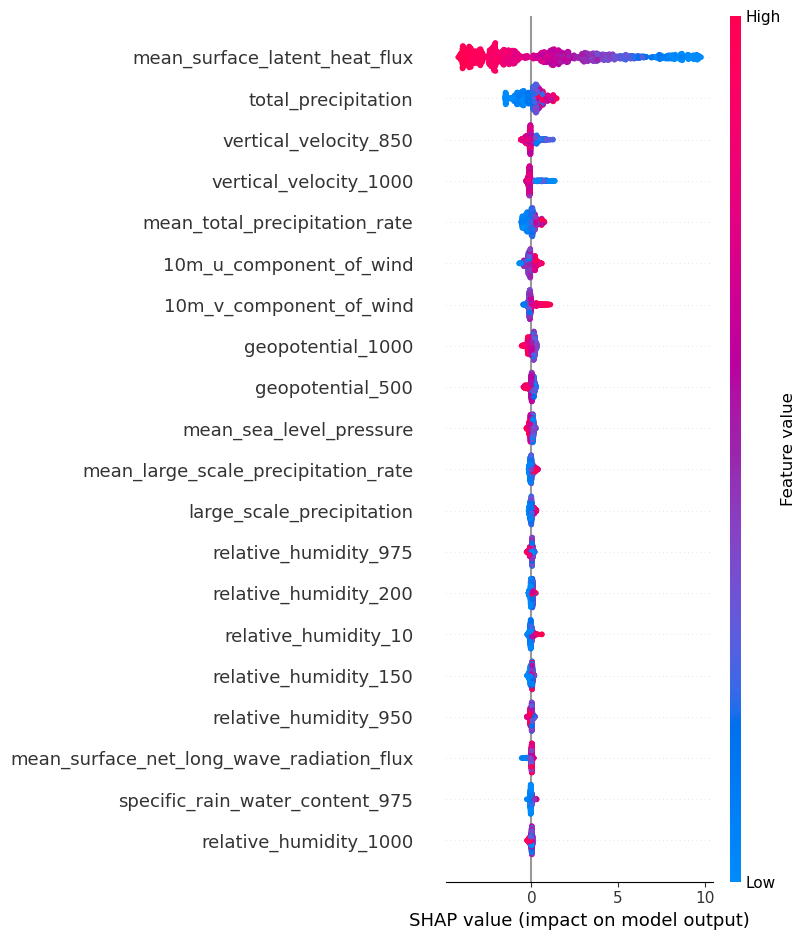

SHAP values for RandomForest, mse with validation set: 5.929452270224629


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


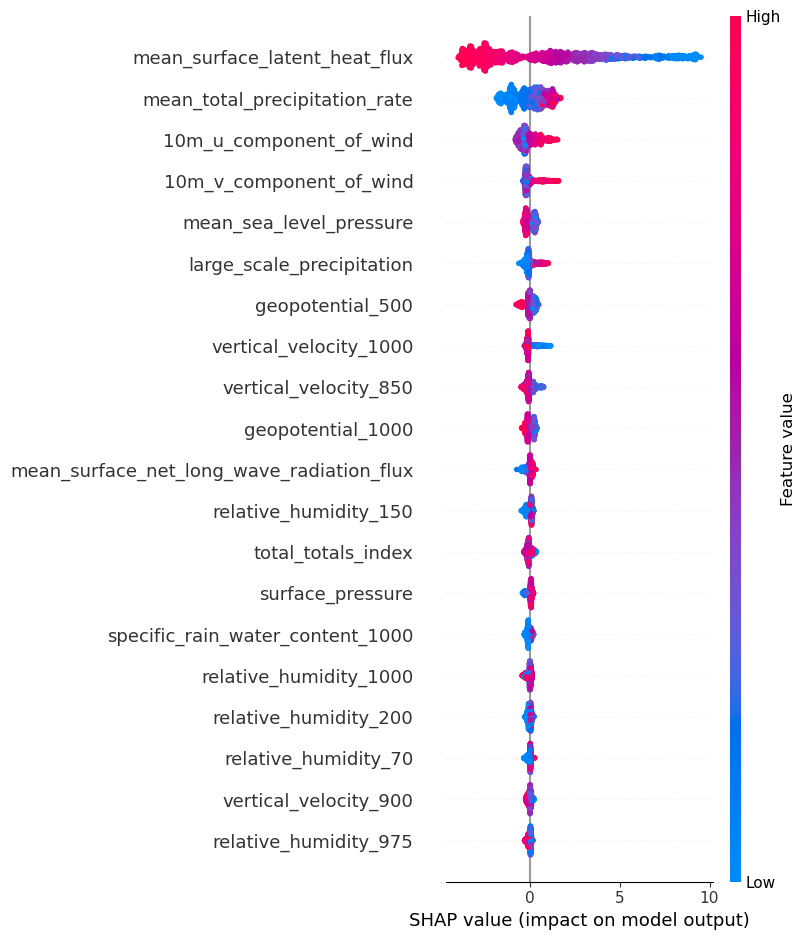

SHAP values for LightGBM, mse with validation set: 5.502255780363145


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


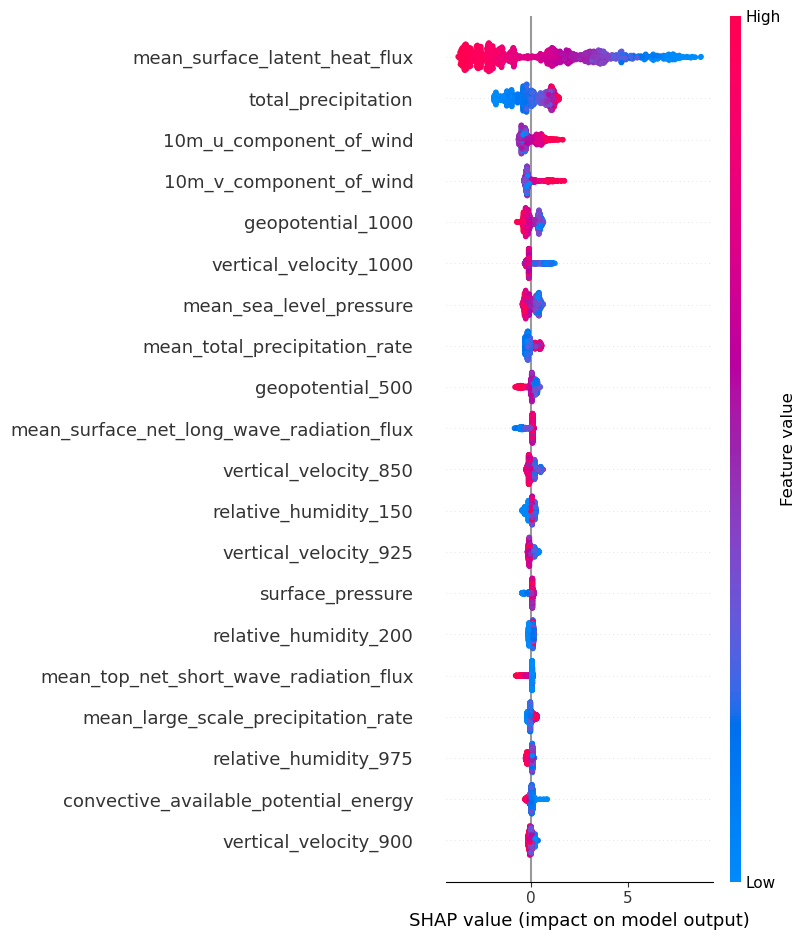

SHAP values for GradientBoosting, mse with validation set: 5.020746150154609


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


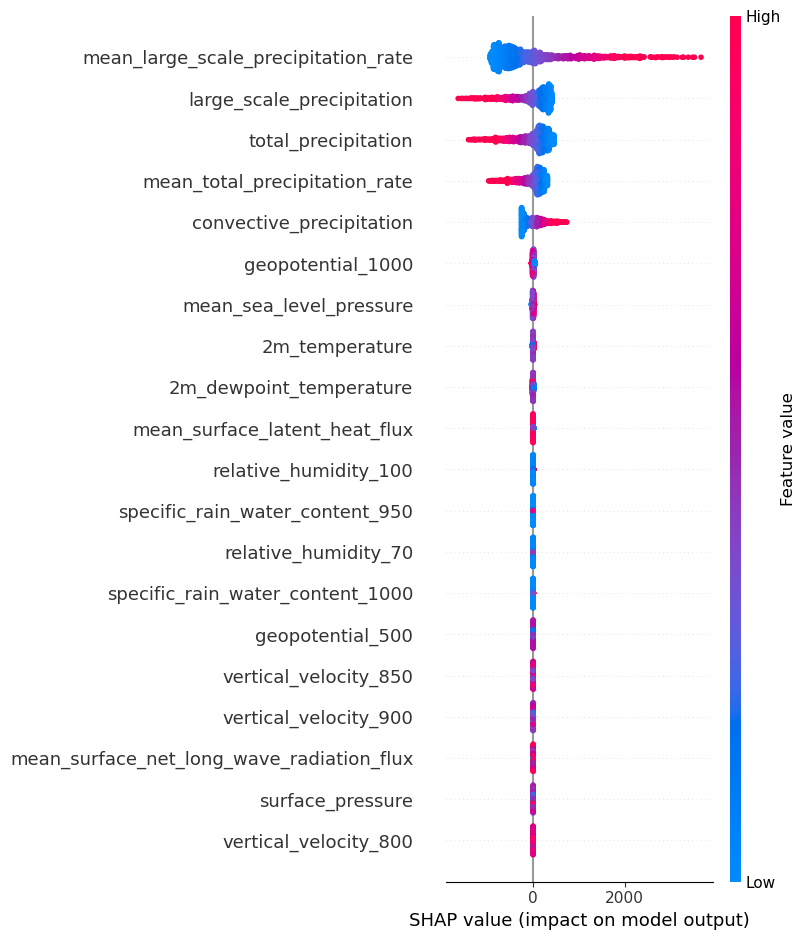

SHAP values for LinearRegression, mse with validation set: 4.041362934992779


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


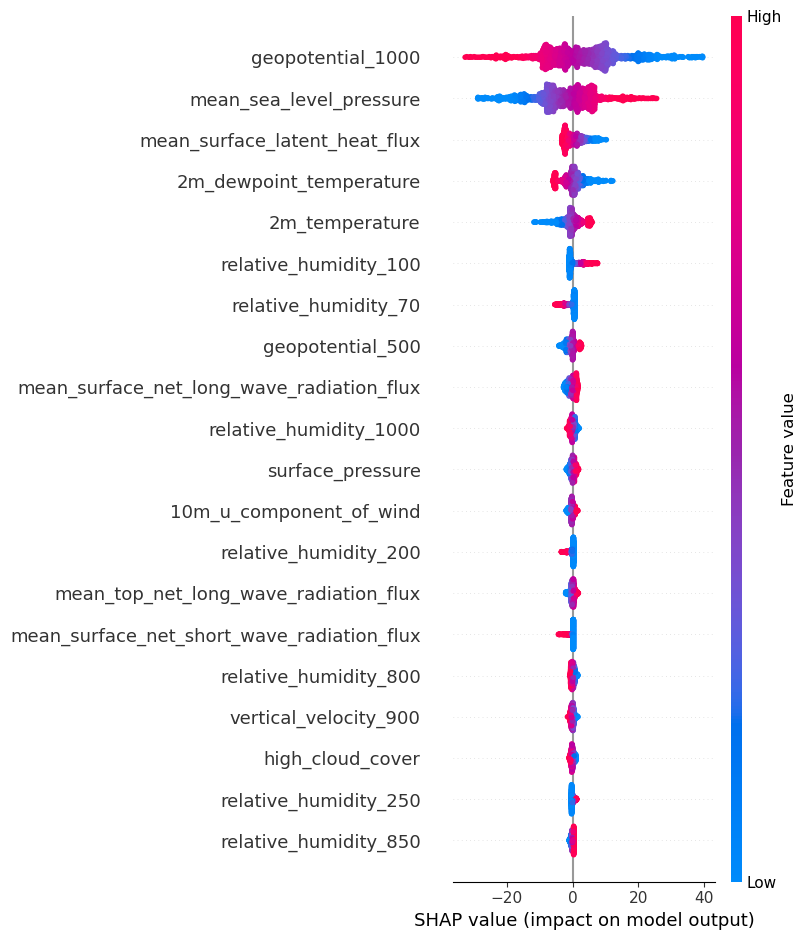

SHAP values for Ridge, mse with validation set: 4.569186264024102


In [9]:
for name, study in studies.items():
    if name == 'XGBoost':
        continue
        shap_values = shap.TreeExplainer(regressors[name]).shap_values(X_test)
        shap_interaction_values = shap.TreeExplainer(regressors[name]).shap_interaction_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type="bar")
    explainer = shap.Explainer(regressors[name], X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, title=name)
    print(f"SHAP values for {name}, mse with validation set: {mean_squared_error(y_validation, regressors[name].predict(X_validation))}")
    

mse with validation set for RandomForest: 5.929452270224629
mse with test set for RandomForest: 6.065920658969053
mse with train set for RandomForest: 0.0827666226954747


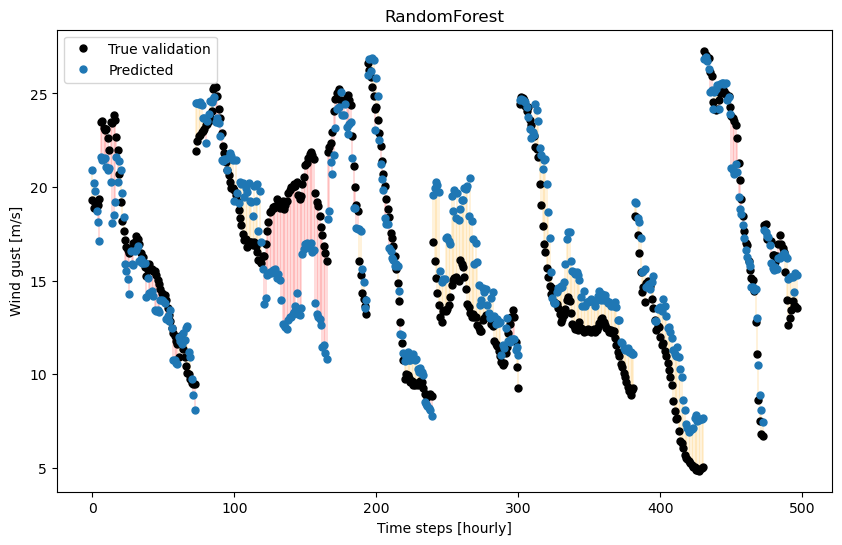

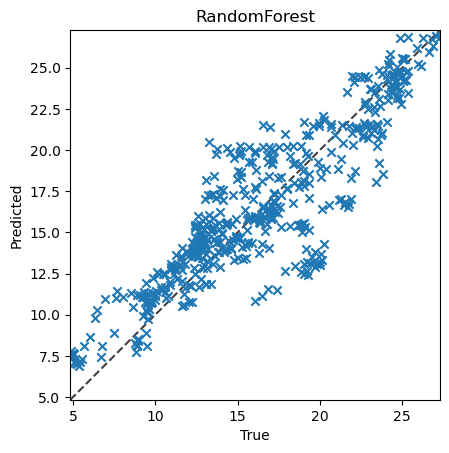

mse with validation set for LightGBM: 5.502255780363145
mse with test set for LightGBM: 5.2909540737138006
mse with train set for LightGBM: 0.11353887763962266


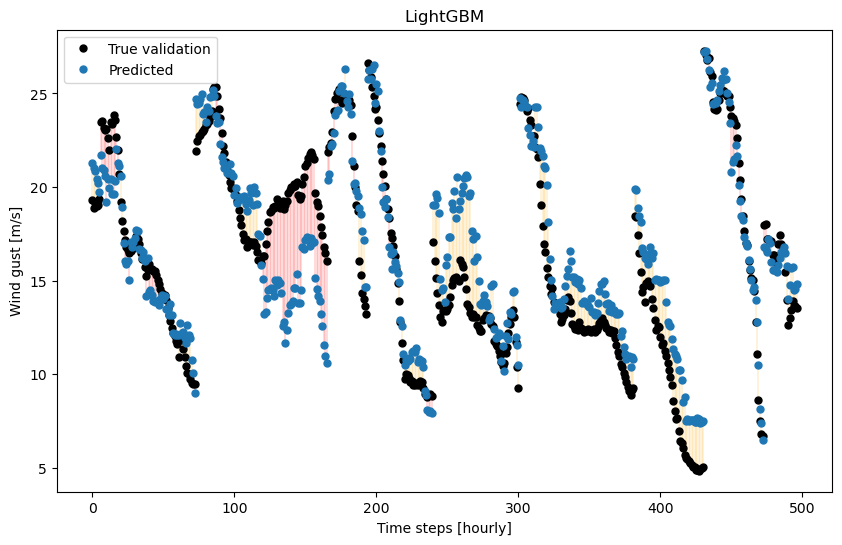

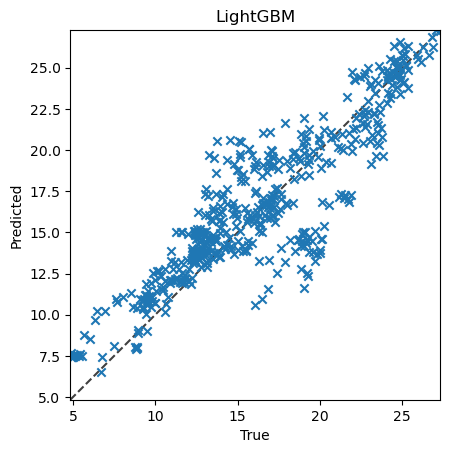

mse with validation set for XGBoost: 6.072021719297901
mse with test set for XGBoost: 5.149497257825466
mse with train set for XGBoost: 0.015654044122460766


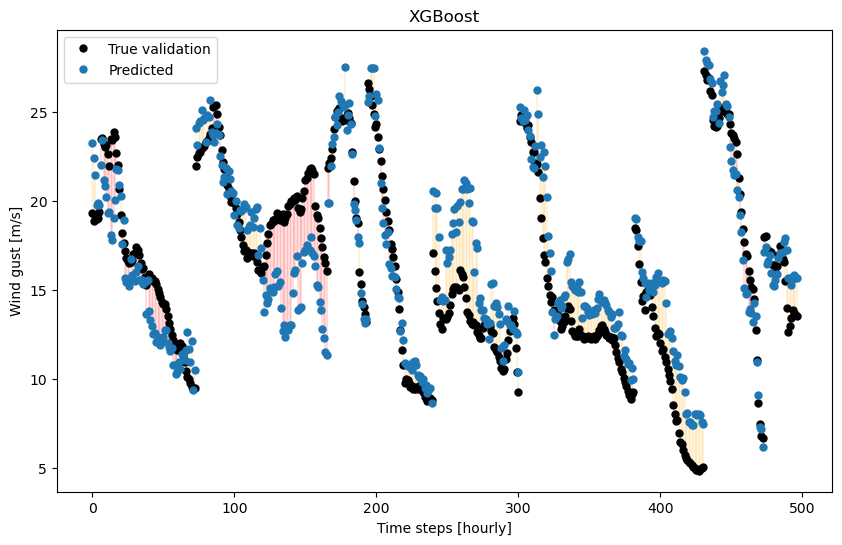

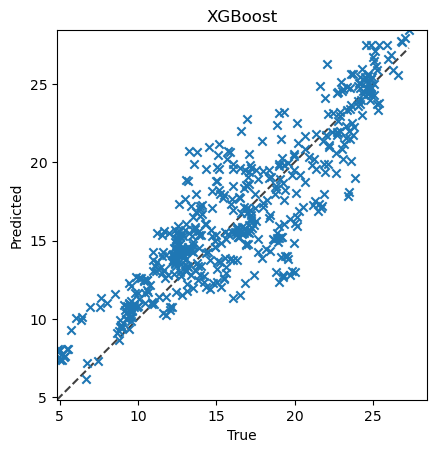

mse with validation set for GradientBoosting: 5.020746150154609
mse with test set for GradientBoosting: 4.992253332316019
mse with train set for GradientBoosting: 0.8732771908192648


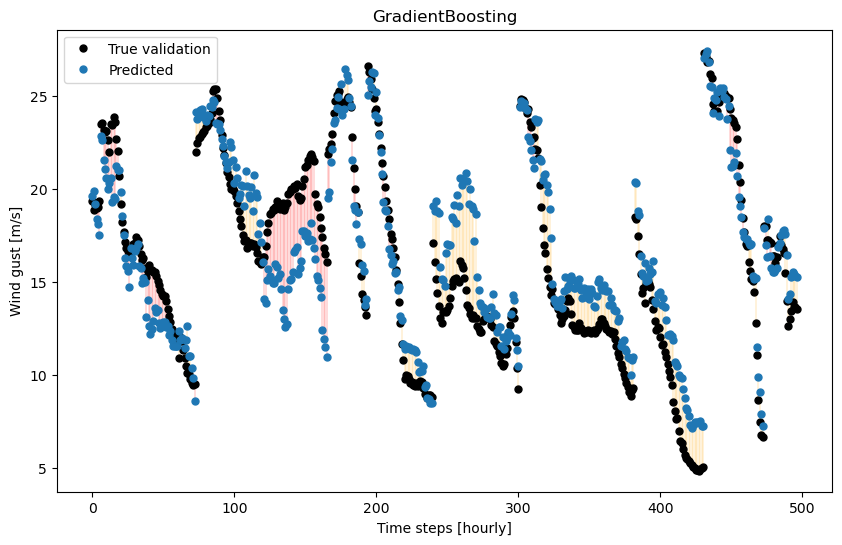

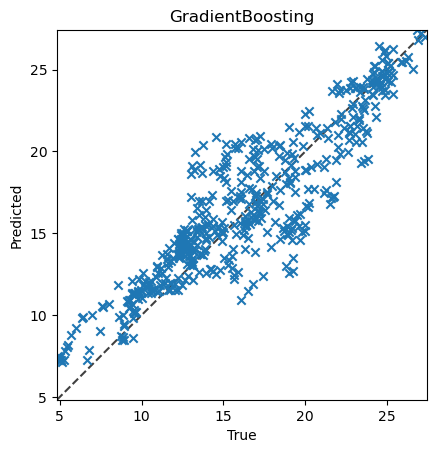

mse with validation set for LinearRegression: 4.041362934992779
mse with test set for LinearRegression: 5.082993278915512
mse with train set for LinearRegression: 2.0006848469475873


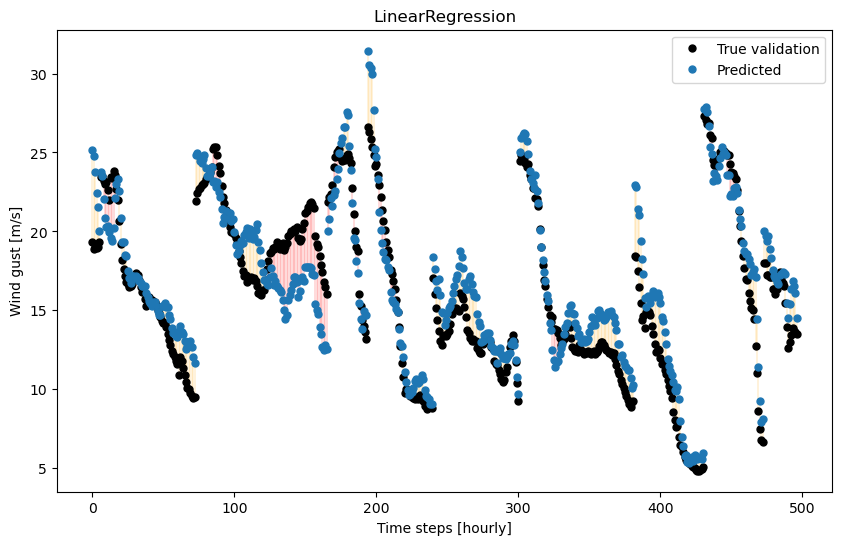

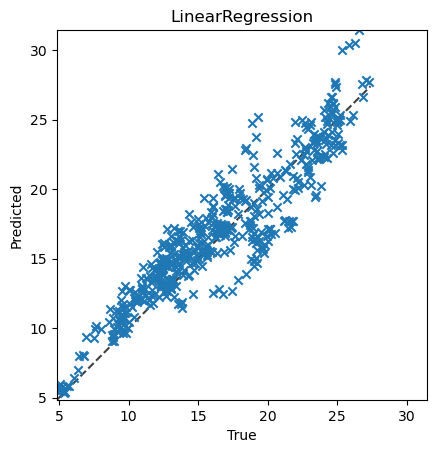

mse with validation set for Ridge: 4.569186264024102
mse with test set for Ridge: 4.751353582448972
mse with train set for Ridge: 2.529769997196271


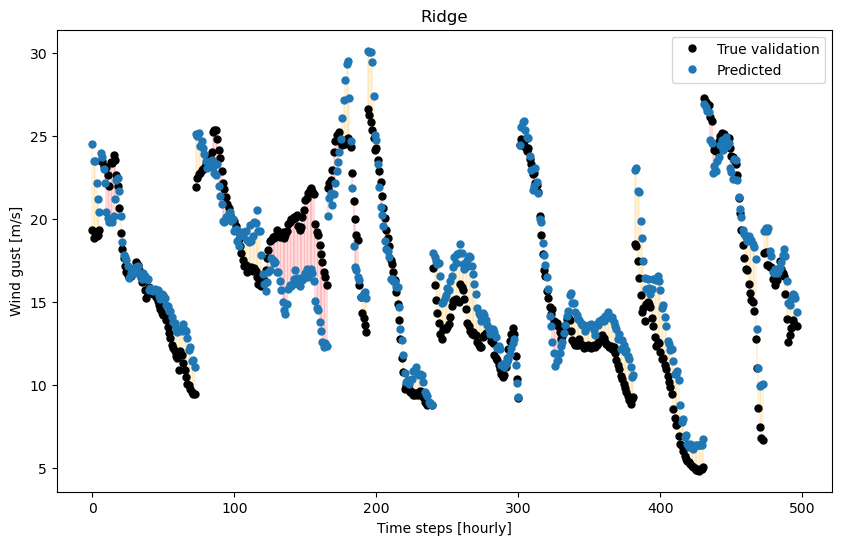

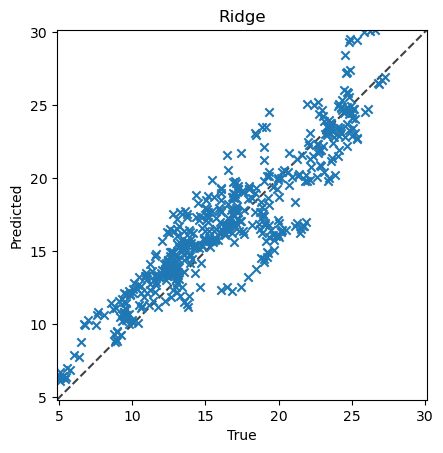

In [66]:
# see the prediction over the validation set for each model using plot

import matplotlib.pyplot as plt

thickness = 0.2

for name, study in studies.items():
    print(f"mse with validation set for {name}: {mean_squared_error(y_validation, regressors[name].predict(X_validation))}")
    print(f"mse with test set for {name}: {mean_squared_error(y_test, regressors[name].predict(X_test))}")
    print(f"mse with train set for {name}: {mean_squared_error(y_train, regressors[name].predict(X_train))}")
    predictions = regressors[name].predict(X_validation)
    errors = y_validation.values.ravel() - predictions

    # Assuming y_validation and X_validation are defined
    predictions = regressors[name].predict(X_validation)
    errors = y_validation.values.ravel() - predictions

    plt.figure(figsize=(10, 6))

    # Add vertical lines for error bars with color based on prediction vs true value
    for i in range(len(predictions)):
        color = 'orange' if predictions[i] > y_validation.values.ravel()[i] else 'red'
        plt.vlines(x=i, ymin=min(y_validation.values.ravel()[i], predictions[i]), ymax=max(y_validation.values.ravel()[i], predictions[i]), color=color, linewidth = thickness)

    plt.plot(y_validation, 'o', color='black', markersize=5, label='True validation')
    plt.plot(predictions, 'o', markersize=5, label='Predicted')

    plt.legend()
    plt.xlabel('Time steps [hourly]')
    plt.ylabel('Wind gust [m/s]')
    plt.title(name)
    plt.show()

    # Add a diagonal line for reference
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    plt.scatter(y_validation, regressors[name].predict(X_validation), marker='x')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(name)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

# Set the limits of both axes to be the same
    lims = [
        min(min(y_validation.values.ravel()), min(predictions)),  # min of both axes
        max(max(y_validation.values.ravel()), max(predictions))   # max of both axes
    ]
    plt.xlim(lims)
    plt.ylim(lims)

    plt.show()


In [45]:
y_validation.values.ravel()[i]

19.33121